## IBM Data Science Professional Certificate Capstone Project

April 2021

## Table of Contents
### [1.Introduction.](#1introduction)
### [2.Data.](#2data)
### [3.Methodology.](#3Methodology) 
### [4.Preparation of the demographics data.](#4demographicsdata) 
### [5.Generating the clusters and evaluating their quality.](#5clusters) 
### [6.Analysis of the clusters' demographics and land area.](#6) 
### [7.Visualisation of the selected clusters on the San Francisco map.](#7) 
### [8.Downloading data about restaurants in cluster 2 of 4.](#8)
### [9.Visualising restaurants in cluster 2 of 4 and its vicinity on the map. ](#9)
### [10.Conclusion](#10)


## 1. Introduction  <a name="1introduction"></a>

The goal of this project will be to find the best location for a Mexican restaurant in San Francisco, CA. As defined by the Investor this will be a restaurant aimed mainly at 30-49 year old clientele with income above 100k$ per annum. One of the main attractions will be the high quality of the food. At first we assume the the main customers will be the inhabitants of the neighboring areas, with a strong emphasis on clients with Mexican origin. 

Firstly I will analyse the the demographics of San Francisco to identify the market area with the optimum clientele base inline with the above assumptions. 
Secondly I will look into the selected area, examine the competition and pinpoint a more precise location. The analysis will be valueable for anyone planning to open a similar Mexican restaurant in San Francisco.


## 2. Data <a name="2data"></a>

I will use census tracts data obtained from openICPSR for the demographics analysis of the San Francisco - (National Neighborhood Data Archive (NaNDA): Socioeconomic Status and Demographic Characteristics of Census Tracts, United States, 2008-2017). ICPSR is an Inter-university Consortium for Political and Social Research.
Machine learning clustering on the relevant census tracts data will be carried out to identify the preferable neighboorhood.
The key data used to cluster the tracts will be:
* the average number of the population with income above 100k USD per year per square mile,  
* the average number of the Hispanic population per square mile- the majority of Hispanic population in SanFrancisco are of Mexican origin,
* the average number of the 30-49 year old population per square mile,

Additionally the land area of each tract will be taken into consideration.

The geojson census tracts file used for the maps was obtained from Metropolitan Transportation Commission (MTC) website, the transportation planning, coordinating and financing agency for the nine-county San Francisco Bay Area.

Information about the the competition in the selected area will be obtained with the Foursquare API. Two key factors will analysed using this data:
* location of other Mexican restaurants - the restaurant should be located as far as possible from the direct competitors,
* location of other restaurants - locating the restaurant next to other restaurants which are not direct competitors could be even beneficial (poossiblity of taking over their clients).

## 3. Methodology <a name="3Methodology"></a>
* Initially I will convert the proportion of the population with income above 100k USD, Hispanic population and 30-49 year old population to average number of each type of population per square mile.
* My next step will be scaling the data using the minmax scaler in order to use it for clustering using the Kmeans algorithm,
* I will evaluate the impact of dividing the tracts into different number of clusters on the quality of the clusters using the yellowbrick library,
* Subsequently I will assess which cluster would be the most suitable, considering its demographics and size, for the location of the Mexican restaurant, 
* Finally I will use the data from the Foursquare api in order to pinpoint a more precise location of the restaurant, ensuring it is located as far as possible from the direct competitors 

## 4. Preparation of the demographics data. <a name="4demographicsdata"></a>

In [169]:
import pandas as pd
import numpy as np

Reading information about the demographics of San Francisco census tracts in terms of:
1. Persons per square mile, ACS 2013-2017 (popden13_17)
3. Proportion of people of Hispanic origin, ACS 2013-2017 (phispanic13_17)
3. Proportion of families with income greater than 100K, ACS 2013-2017 (inc_above_100k)
4. Proportion of population 30-49 years of age, ACS 2013-2017 (30-39_pop)
5. Land area of each tract (land_area)



In [171]:
demogr_sf_res.describe()

popden13_17  phispanic13_17  inc_above_100k   30-49_pop   land_area
count     197.000000      197.000000      197.000000  197.000000  197.000000
mean    30705.343058        0.150408        0.539242    0.339857    0.237933
std     22463.860966        0.118301        0.220854    0.089740    0.278395
min         0.000000        0.000000        0.000000    0.000000    0.000000
25%     19862.460000        0.065402        0.381136    0.279339    0.113413
50%     26842.250000        0.111238        0.567935    0.335698    0.158258
75%     36030.870000        0.191804        0.705506    0.405110    0.254182
max    156680.800000        0.617953        0.947226    0.632231    2.358635

In [172]:
demogr_sf_res.dtypes

trctid             object
popden13_17       float64
phispanic13_17    float64
inc_above_100k    float64
30-49_pop         float64
land_area         float64
dtype: object

Calculating the the average number of persons of Hispanic origin, with income above 100k USD and aged 30-49 per square mile for each census tract.

In [173]:
demogr_sf_res_avg=pd.DataFrame()
demogr_sf_res_avg['trctid']=demogr_sf_res['trctid']
demogr_sf_res_avg['avg_hisp']=demogr_sf_res['popden13_17']*demogr_sf_res['phispanic13_17']
demogr_sf_res_avg['avg_inc_above_100k']=demogr_sf_res['popden13_17']*demogr_sf_res['inc_above_100k']
demogr_sf_res_avg['avg_30-49_pop']=demogr_sf_res['popden13_17']*demogr_sf_res['30-49_pop']
demogr_sf_res_avg['land_area']=demogr_sf_res['land_area']
demogr_sf_res_avg

trctid     avg_hisp  avg_inc_above_100k  avg_30-49_pop  land_area
0    06075010100   927.280282         5693.425998    5220.121250   0.299801
1    06075010200   673.152074        15463.014831    8027.589366   0.199064
2    06075010300  3910.093326        21586.323342   16364.464002   0.103578
3    06075010400  4204.300087        24951.551587   15598.339407   0.129629
4    06075010500  1087.266095         6478.947501    3231.491081   0.263965
..           ...          ...                 ...            ...        ...
192  06075980401     0.000000            0.000000       0.000000   0.161902
193  06075980501   240.195549          399.304688     189.542075   0.612001
194  06075980600   108.103664          253.140225     155.474939   0.823284
195  06075980900    41.886091          109.228813     110.492619   1.384708
196  06075990100     0.000000            0.000000       0.000000   0.000000

[197 rows x 5 columns]

In [174]:
train_data=demogr_sf_res_avg.iloc[:,1:4]

In [175]:
train_data

avg_hisp  avg_inc_above_100k  avg_30-49_pop
0     927.280282         5693.425998    5220.121250
1     673.152074        15463.014831    8027.589366
2    3910.093326        21586.323342   16364.464002
3    4204.300087        24951.551587   15598.339407
4    1087.266095         6478.947501    3231.491081
..           ...                 ...            ...
192     0.000000            0.000000       0.000000
193   240.195549          399.304688     189.542075
194   108.103664          253.140225     155.474939
195    41.886091          109.228813     110.492619
196     0.000000            0.000000       0.000000

[197 rows x 3 columns]

I am scaling the data using the minmax scaler in order to use it for clustering using the Kmeans algorithm

In [176]:
from sklearn.compose import  ColumnTransformer
from sklearn.preprocessing import MinMaxScaler
ct=ColumnTransformer([('scaler',MinMaxScaler(),['avg_hisp','avg_inc_above_100k','avg_30-49_pop'])])
scaled_td=ct.fit_transform(train_data)


## 5. Generating the clusters and evaluating their quality. <a name="5clusters"></a>

In the next step I will cluster the census tracts using Kmeans algorithm considering the above data in order to find the optimal market area for the restaurant. I will evaluate the impact of dividing the tracts into different number of clusters on the quality of the clusters using the Yellowbrick library.

I will evaluate what is the optimal number of clusters between the range of 3 and 9 using the yellowbrick silhuette visualizer.

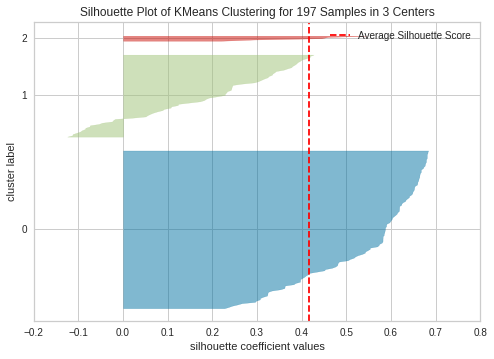

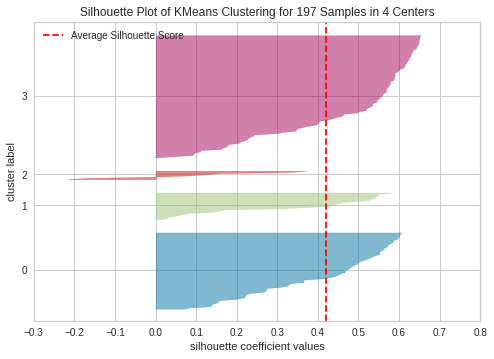

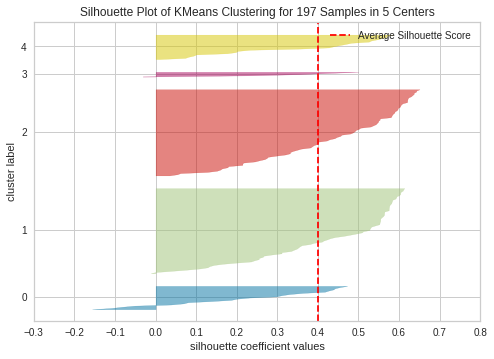

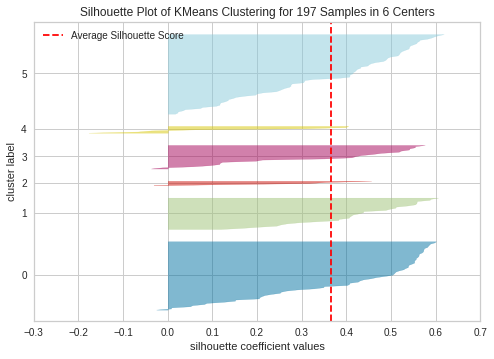

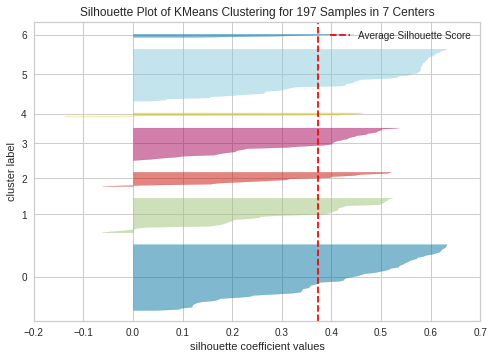

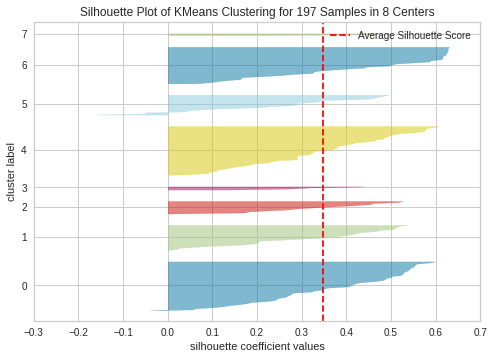

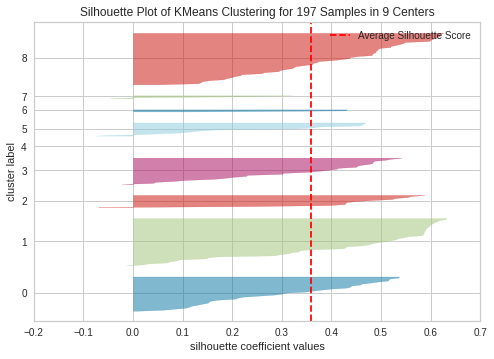

In [177]:
from yellowbrick.cluster import SilhouetteVisualizer
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
for k in range(3,10):
    kms=KMeans(n_clusters=k,random_state=5)
    visualizer = SilhouetteVisualizer(kms, colors='yellowbrick')
    visualizer.fit(scaled_td)
    visualizer.show()

Silhouette score for a set of sample data points is used to measure how dense and well-separated the clusters are.
The value of the Silhouette score varies from -1 to 1. If the score is 1, the cluster is dense and well-separated than other clusters. A value near 0 represents overlapping clusters with samples very close to the decision boundary of the neighboring clusters. A negative score indicates that the samples might have got assigned to the wrong clusters.
It is also a negative symptom if there are clusters below the average silhuette score.
After an intitial assesment we can see that most likely we can disregard options with 3, 4 and 5 clusters considering the following:
* cluster 1 of the 3 clusters option has a large number of samples with a negative score 
* cluster 2 of the 4 clusters option has some number of samples with a negative score and its score is below the average score
* cluster 0 of the 5 clusters option has a significant number of samples with a negative score
Out of the the other options the option with seven clusters looks most promising as it does not have clusters with a significant number of negative scores or clusters with scores below the average score and it has the highest average score out of the options with more clusters then 5.
We will have a better understanding how well each clustering options suits our requirements when we analyse each of the clusters in terms of their demographics.


## 6. Analysis of the clusters' demographics and land area <a name="6"></a>

In [178]:
demogr_sf_res_avg.describe()

avg_hisp  avg_inc_above_100k  avg_30-49_pop   land_area
count    197.000000          197.000000     197.000000  197.000000
mean    4944.686772        15457.786199   10577.024629    0.237933
std     6420.243833        10152.912164    8075.466483    0.278395
min        0.000000            0.000000       0.000000    0.000000
25%     1450.268496         9008.583807    5873.239622    0.113413
50%     2914.469614        13853.137914    9203.147634    0.158258
75%     5439.174669        20435.035732   13164.907394    0.254182
max    39646.417008        67092.308299   57851.690639    2.358635

I will generate cluster labeles for each of the clustering options.

In [226]:
from sklearn.cluster import KMeans
def gen_clusters(l=3,h=9):
    for k in range(l,h+1):
        kms=KMeans(n_clusters=k,random_state=5).fit(scaled_td)
        demogr_sf_res_avg[[str(k)+'_clusters']]=kms.labels_

           

In [227]:

gen_clusters()
demogr_sf_res_avg

trctid     avg_hisp  avg_inc_above_100k  avg_30-49_pop  land_area  \
0    06075010100   927.280282         5693.425998    5220.121250   0.299801   
1    06075010200   673.152074        15463.014831    8027.589366   0.199064   
2    06075010300  3910.093326        21586.323342   16364.464002   0.103578   
3    06075010400  4204.300087        24951.551587   15598.339407   0.129629   
4    06075010500  1087.266095         6478.947501    3231.491081   0.263965   
..           ...          ...                 ...            ...        ...   
192  06075980401     0.000000            0.000000       0.000000   0.161902   
193  06075980501   240.195549          399.304688     189.542075   0.612001   
194  06075980600   108.103664          253.140225     155.474939   0.823284   
195  06075980900    41.886091          109.228813     110.492619   1.384708   
196  06075990100     0.000000            0.000000       0.000000   0.000000   

     3_clusters  4_clusters  5_clusters  6_clusters  7_clusters  8_clusters  \
0             0           3           1           0           5           6   
1             0           3           2           5           0           4   
2             1           0           2           1           1           0   
3             1           0           2           1           1           0   
4             0           3           1           0           5           6   
..          ...         ...         ...         ...         ...         ...   
192           0           3           1           0           5           6   
193           0           3           1           0           5           6   
194           0           3           1           0           5           6   
195           0           3           1           0           5           6   
196           0           3           1           0           5           6   

     9_clusters  
0             1  
1             8  
2             0  
3             0  
4             1  
..          ...  
192           1  
193           1  
194           1  
195           1  
196           1  

[197 rows x 12 columns]

In [228]:
 def eval_clusters(df=demogr_sf_res_avg,l=3,h=9):
        ev_clusters=pd.DataFrame()
        for k in range(l,h+1):
            if ev_clusters.empty:
                ev_clusters= df.groupby([str(k)+'_clusters']).agg({
                'avg_hisp': 'mean',
                'avg_inc_above_100k': 'mean',
                'avg_30-49_pop': 'mean',
                'land_area': sum
                })
                ev_clusters['nr_of_clusters']='_of_'+str(k)+'_clusters'           
            else:
                next_df=df.groupby([str(k)+'_clusters']).agg({
                'avg_hisp': 'mean',
                'avg_inc_above_100k': 'mean',
                'avg_30-49_pop': 'mean',
                'land_area': sum
                })
                next_df['nr_of_clusters']='_of_'+str(k)+'_clusters'
                ev_clusters=pd.concat([ev_clusters,next_df])
                
        ev_clusters.rename(columns={'land_area':'cluster_land_area_sum'},inplace=True)
        ev_clusters.reset_index(inplace=True)
        ev_clusters.rename(columns={'index':'cluster_nr'},inplace=True)
        #ev_clusters['avg_dem']=  ev_clusters['avg_hisp']+ev_clusters['avg_inc_above_100k']+ev_clusters['avg_30-49_pop']
        ev_clusters['avg_dem']=ev_clusters[['avg_hisp','avg_inc_above_100k','avg_30-49_pop']].mean(axis=1)
        #ev_clusters['sort_param']=ev_clusters['sort_param']*ev_clusters['cluster_land_area_sum']
        ev_clusters=ev_clusters.sort_values(by='avg_dem',ascending=False)
        ev_clusters['cluster']=ev_clusters['cluster_nr'].astype(str)+ev_clusters['nr_of_clusters']
        ev_clusters.drop(['cluster_nr','nr_of_clusters'],axis=1,inplace=True)
        ev_clusters.drop(['avg_dem'],axis=1,inplace=True)
        ev_clusters.set_index('cluster',inplace=True,drop=True)
        return(ev_clusters)

Next  using the function defined above I am listing the ten most prefarrable clusters sorted by their suitablity as far as their demographics are concerned.

The darker the color of each of the parameter of the tract cluster in the table below reflects it's suitability for the location of the restaurant.

In [229]:
import seaborn as sns
pd.set_option('display.max_rows', 20)
cm=sns.light_palette('green',as_cmap=True)
ev_cl=eval_clusters().head(10)
ev_cl.style.background_gradient(cmap=cm)


Cluster 4 of 9 clusters has the most beneficial demographics parameters but it has also the smallest area which is disadvantageous.
Let us plot the above data.

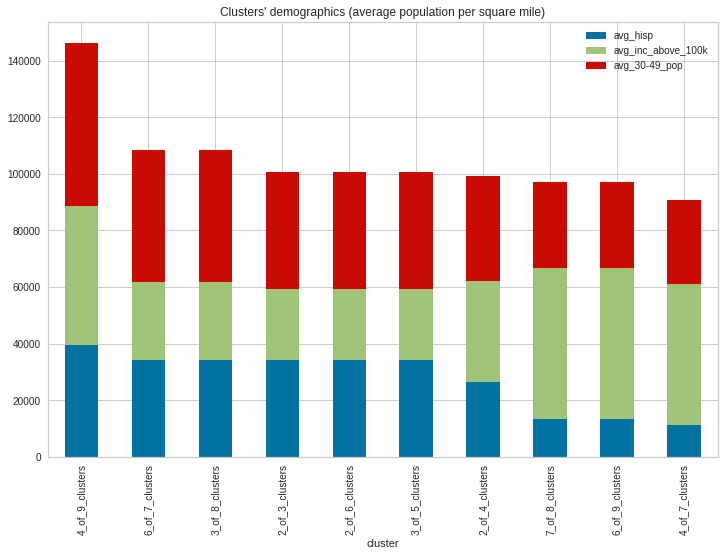

In [230]:
ax=ev_cl.iloc[:,:-1].plot(kind='bar',stacked=True,figsize=(12,8),title="Clusters' demographics (average population per square mile)")

<AxesSubplot:title={'center':"Clusters' land area (square miles)"}, xlabel='cluster'>

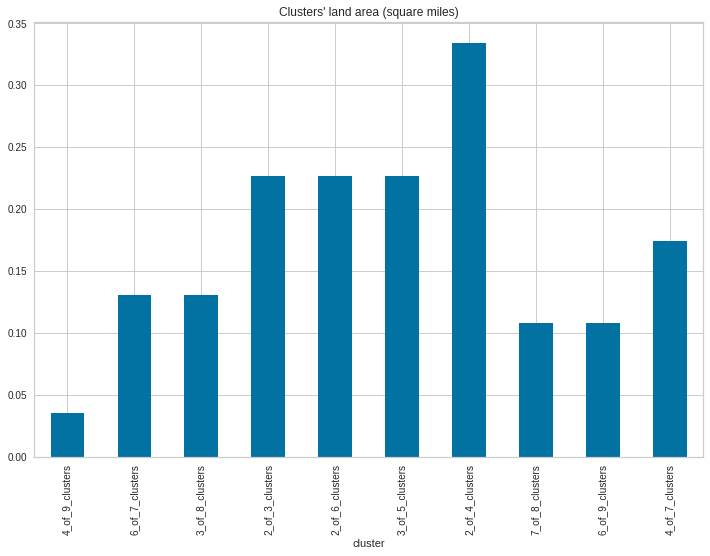

In [231]:
ev_cl.iloc[:,-1].plot(kind='bar',figsize=(12,8),title="Clusters' land area (square miles)")

We see that:

    * cluster 4 of 9 has the most beneficial demographics parameters but it has also the smallest area
    * cluster 6 of 7 has good demographics parameters particularly the age and etnicity and significantly larger area then the previous option
    * cluster 2 of 4 the largest area but a lower demographic suitability in terms of ethnicity and age of the population
 
I will visualise these three selected above clustering  options on the tracts map of the San Francisco county.

## 7. Visualisation of the selected clusters on the San Francisco map. <a name="7"></a>

In [185]:
#html template code for map 1 legend
template = """
{% macro html(this, kwargs) %}

<!doctype html>
<html lang="en">
<head>
  <meta charset="utf-8">
  <meta name="viewport" content="width=device-width, initial-scale=1">
  <title>jQuery UI Draggable - Default functionality</title>
  <link rel="stylesheet" href="//code.jquery.com/ui/1.12.1/themes/base/jquery-ui.css">

  <script src="https://code.jquery.com/jquery-1.12.4.js"></script>
  <script src="https://code.jquery.com/ui/1.12.1/jquery-ui.js"></script>
  
  <script>
  $( function() {
    $( "#maplegend" ).draggable({
                    start: function (event, ui) {
                        $(this).css({
                            right: "auto",
                            top: "auto",
                            bottom: "auto"
                        });
                    }
                });
});

  </script>
</head>
<body>

 
<div id='maplegend' class='maplegend' 
    style='position: absolute; z-index:9999; border:2px solid grey; background-color:rgba(255, 255, 255, 0.8);
     border-radius:6px; padding: 10px; font-size:14px; right: 20px; bottom: 20px;'>
     
<div class='legend-title'>Legend (draggable)</div>
<div class='legend-title'>9 clusters)</div>
<div class='legend-scale'>
  <ul class='legend-labels'>
    <li><span style='background:black;opacity:0.7;'></span>Cluster 0</li>
    <li><span style='background:gray;opacity:0.7;'></span>Cluster 1</li>
    <li><span style='background:blue;opacity:0.7;'></span>Cluster 2</li>
    <li><span style='background:darkred;opacity:0.7;'></span>Cluster 3</li>
    <li><span style='background:yellow;opacity:0.7;'></span>Cluster 4</li>
    <li><span style='background:red;opacity:0.7;'></span>Cluster 5</li>
    <li><span style='background:purple;opacity:0.7;'></span>Cluster 6</li>
    <li><span style='background:cadetblue;opacity:0.7;'></span>Cluster 7</li>
    <li><span style='background:green;opacity:0.7;'></span>Cluster 8</li>
  
  </ul>
</div>
</div>
 
</body>
</html>

<style type='text/css'>
  .maplegend .legend-title {
    text-align: left;
    margin-bottom: 5px;
    font-weight: bold;
    font-size: 90%;
    }
  .maplegend .legend-scale ul {
    margin: 0;
    margin-bottom: 5px;
    padding: 0;
    float: left;
    list-style: none;
    }
  .maplegend .legend-scale ul li {
    font-size: 80%;
    list-style: none;
    margin-left: 0;
    line-height: 18px;
    margin-bottom: 2px;
    }
  .maplegend ul.legend-labels li span {
    display: block;
    float: left;
    height: 16px;
    width: 30px;
    margin-right: 5px;
    margin-left: 0;
    border: 1px solid #999;
    }
  .maplegend .legend-source {
    font-size: 80%;
    color: #777;
    clear: both;
    }
  .maplegend a {
    color: #777;
    }
</style>
{% endmacro %}"""

In [186]:
#html template code for map 2 legend
template1 = """
{% macro html(this, kwargs) %}

<!doctype html>
<html lang="en">
<head>
  <meta charset="utf-8">
  <meta name="viewport" content="width=device-width, initial-scale=1">
  <title>jQuery UI Draggable - Default functionality</title>
  <link rel="stylesheet" href="//code.jquery.com/ui/1.12.1/themes/base/jquery-ui.css">

  <script src="https://code.jquery.com/jquery-1.12.4.js"></script>
  <script src="https://code.jquery.com/ui/1.12.1/jquery-ui.js"></script>
  
  <script>
  $( function() {
    $( "#maplegend" ).draggable({
                    start: function (event, ui) {
                        $(this).css({
                            right: "auto",
                            top: "auto",
                            bottom: "auto"
                        });
                    }
                });
});

  </script>
</head>
<body>

 
<div id='maplegend' class='maplegend' 
    style='position: absolute; z-index:9999; border:2px solid grey; background-color:rgba(255, 255, 255, 0.8);
     border-radius:6px; padding: 10px; font-size:14px; right: 20px; bottom: 20px;'>
     
<div class='legend-title'>Legend (draggable)</div>
<div class='legend-title'>4 clusters)</div>
<div class='legend-scale'>   
  <ul class='legend-labels'>
    <li><span style='background:green;opacity:0.7;'></span>Cluster 0</li>
    <li><span style='background:blue;opacity:0.7;'></span>Cluster 1</li>
    <li><span style='background:yellow;opacity:0.7;'></span>Cluster 2</li>
    <li><span style='background:gray;opacity:0.7;'></span>Cluster 3</li>
  
  </ul>
</div>
</div>
 
</body>
</html>

<style type='text/css'>
  .maplegend .legend-title {
    text-align: left;
    margin-bottom: 5px;
    font-weight: bold;
    font-size: 90%;
    }
  .maplegend .legend-scale ul {
    margin: 0;
    margin-bottom: 5px;
    padding: 0;
    float: left;
    list-style: none;
    }
  .maplegend .legend-scale ul li {
    font-size: 80%;
    list-style: none;
    margin-left: 0;
    line-height: 18px;
    margin-bottom: 2px;
    }
  .maplegend ul.legend-labels li span {
    display: block;
    float: left;
    height: 16px;
    width: 30px;
    margin-right: 5px;
    margin-left: 0;
    border: 1px solid #999;
    }
  .maplegend .legend-source {
    font-size: 80%;
    color: #777;
    clear: both;
    }
  .maplegend a {
    color: #777;
    }
</style>
{% endmacro %}"""

In [187]:
#html template code for map 3 legend
template2 = """
{% macro html(this, kwargs) %}

<!doctype html>
<html lang="en">
<head>
  <meta charset="utf-8">
  <meta name="viewport" content="width=device-width, initial-scale=1">
  <title>jQuery UI Draggable - Default functionality</title>
  <link rel="stylesheet" href="//code.jquery.com/ui/1.12.1/themes/base/jquery-ui.css">

  <script src="https://code.jquery.com/jquery-1.12.4.js"></script>
  <script src="https://code.jquery.com/ui/1.12.1/jquery-ui.js"></script>
  
  <script>
  $( function() {
    $( "#maplegend" ).draggable({
                    start: function (event, ui) {
                        $(this).css({
                            right: "auto",
                            top: "auto",
                            bottom: "auto"
                        });
                    }
                });
});

  </script>
</head>
<body>

 
<div id='maplegend' class='maplegend' 
    style='position: absolute; z-index:9999; border:2px solid grey; background-color:rgba(255, 255, 255, 0.8);
     border-radius:6px; padding: 10px; font-size:14px; right: 20px; bottom: 20px;'>
     
<div class='legend-title'>Legend (draggable)</div>
<div class='legend-title'>7 clusters)</div>
<div class='legend-scale'>
  <ul class='legend-labels'>  
    <li><span style='background:green;opacity:0.7;'></span>Cluster 0</li>
    <li><span style='background:black;opacity:0.7;'></span>Cluster 1</li>
    <li><span style='background:blue;opacity:0.7;'></span>Cluster 2</li>
    <li><span style='background:darkred;opacity:0.7;'></span>Cluster 3</li>
    <li><span style='background:red;opacity:0.7;'></span>Cluster 4</li>
    <li><span style='background:gray;opacity:0.7;'></span>Cluster 5</li>
    <li><span style='background:yellow;opacity:0.7;'></span>Cluster 6</li>

  
  </ul>
</div>
</div>
 
</body>
</html>

<style type='text/css'>
  .maplegend .legend-title {
    text-align: left;
    margin-bottom: 5px;
    font-weight: bold;
    font-size: 90%;
    }
  .maplegend .legend-scale ul {
    margin: 0;
    margin-bottom: 5px;
    padding: 0;
    float: left;
    list-style: none;
    }
  .maplegend .legend-scale ul li {
    font-size: 80%;
    list-style: none;
    margin-left: 0;
    line-height: 18px;
    margin-bottom: 2px;
    }
  .maplegend ul.legend-labels li span {
    display: block;
    float: left;
    height: 16px;
    width: 30px;
    margin-right: 5px;
    margin-left: 0;
    border: 1px solid #999;
    }
  .maplegend .legend-source {
    font-size: 80%;
    color: #777;
    clear: both;
    }
  .maplegend a {
    color: #777;
    }
</style>
{% endmacro %}"""

In [188]:
import geopandas as gpd

geosan = gpd.read_file(r'__San_Francisco_Bay_Region_2010_Census_Tracts_(clipped).geojson', driver='GeoJSON')
demogr_sf_res.rename(columns={'tract_fips10':'trctid'},inplace=True)
geosan=pd.merge(geosan,demogr_sf_res,how='right',on='trctid')

geosan

objectid fipst fipco       trctid              trctname  Shape__Area  \
0       664.0    06   075  06075010100      Census Tract 101     0.000079   
1       665.0    06   075  06075010200      Census Tract 102     0.000053   
2       666.0    06   075  06075010300      Census Tract 103     0.000027   
3       667.0    06   075  06075010400      Census Tract 104     0.000034   
4       668.0    06   075  06075010500      Census Tract 105     0.000070   
..        ...   ...   ...          ...                   ...          ...   
192     856.0    06   075  06075980401  Census Tract 9804.01     0.000043   
193     857.0    06   075  06075980501  Census Tract 9805.01     0.000162   
194     858.0    06   075  06075980600     Census Tract 9806     0.000218   
195     859.0    06   075  06075980900     Census Tract 9809     0.000367   
196       NaN   NaN   NaN  06075990100                   NaN          NaN   

     Shape__Length                                           geometry  \
0         0.214358  POLYGON ((-122.40060 37.80603, -122.40041 37.8...   
1         0.048540  MULTIPOLYGON (((-122.42663 37.80883, -122.4266...   
2         0.022957  POLYGON ((-122.41489 37.80355, -122.41546 37.8...   
3         0.032687  POLYGON ((-122.40243 37.79939, -122.40262 37.8...   
4         0.087869  POLYGON ((-122.39200 37.79388, -122.39169 37.7...   
..             ...                                                ...   
192       0.073780  MULTIPOLYGON (((-123.00361 37.69325, -123.0027...   
193       0.071783  POLYGON ((-122.40668 37.71922, -122.40697 37.7...   
194       0.188398  MULTIPOLYGON (((-122.38681 37.72431, -122.3867...   
195       0.132279  POLYGON ((-122.37413 37.74498, -122.37416 37.7...   
196            NaN                                               None   

     popden13_17  phispanic13_17  inc_above_100k  30-49_pop  land_area  
0     13232.0900        0.070078        0.430274   0.394505   0.299801  
1     21917.6300        0.030713        0.705506   0.366262   0.199064  
2     42257.9700        0.092529        0.510823   0.387252   0.103578  
3     35832.9800        0.117330        0.696329   0.435307   0.129629  
4     10194.5400        0.106652        0.635531   0.316983   0.263965  
..           ...             ...             ...        ...        ...  
192       0.0000        0.000000        0.000000   0.000000   0.161902  
193    1277.7750        0.187980        0.312500   0.148338   0.612001  
194     623.1144        0.173489        0.406250   0.249513   0.823284  
195     174.7661        0.239669        0.625000   0.632231   1.384708  
196       0.0000        0.000000        0.000000   0.000000   0.000000  

[197 rows x 13 columns]

Plotting the 9 clusters option with the preferred cluster 4 in yellow.

In [238]:
import folium
import branca.colormap as cmp
clusters=demogr_sf_res_avg.set_index('trctid')['9_clusters']+1
step = cmp.StepColormap(
 ['black','gray','blue','darkred','yellow','red','purple','cadetblue','green'],
 vmin=0, vmax=9,
 index=[0,1, 2, 3,4,5,6,7,8,9],  #for change in the colors, not used fr linear
 caption='Clusters'    #Caption for Color scale or Legend
)
sanmap=folium.Map(zoom_start=13,location=[37.77,-122.42])
folium.GeoJson(geosan,style_function=lambda feature: {
    'fillColor':step(clusters[feature['properties']['trctid']]),
    'fillOpacity':0.6,
    'color':'black', #border color for the color fills
    'weight':1, #how thick the border has to be
    'dashArray': '5,3' #dashed lines length,space between them
}).add_to(sanmap)

 
from branca.element import Template, MacroElement

macro = MacroElement()
macro._template = Template(template)

sanmap.get_root().add_child(macro)
sanmap

We can see above the location of the tract 4_of_9 with the most preferable demographics.

Plotting the 7 clusters option with the preferred cluster 6 in yellow.

In [190]:
import folium
import branca.colormap as cmp
clusters=demogr_sf_res_avg.set_index('trctid')['7_clusters']+1
step = cmp.StepColormap(
 ['green','black','blue','darkred','red','gray','yellow'],
 vmin=0, vmax=7,
 index=[0,1, 2, 3,4,5,6,7],  #for change in the colors, not used fr linear
 caption='Clusters'    #Caption for Color scale or Legend
)
sanmap=folium.Map(zoom_start=13,location=[37.77,-122.42])
folium.GeoJson(geosan,style_function=lambda feature: {
    'fillColor':step(clusters[feature['properties']['trctid']]),
    'fillOpacity':0.6,
    'color':'black', #border color for the color fills
    'weight':1, #how thick the border has to be
    'dashArray': '5,3' #dashed lines length,space between them
}).add_to(sanmap)

from branca.element import Template, MacroElement

macro = MacroElement()
macro._template = Template(template2)

sanmap.get_root().add_child(macro)
sanmap

We see that that cluster 6 of 7 incorporates cluster 4 of 9.

Plotting below the 4 clusters option with the preferred cluster 2 in yellow.

In [191]:
import folium
import branca.colormap as cmp
clusters=demogr_sf_res_avg.set_index('trctid')['4_clusters']+1
step = cmp.StepColormap(
 ['green','blue','yellow','gray','yellow'],
 vmin=0, vmax=4,
 index=[0,1, 2, 3,4,5],  #for change in the colors, not used fr linear
 caption='Clusters'    #Caption for Color scale or Legend
)
sanmap=folium.Map(zoom_start=13,location=[37.77,-122.42])
folium.GeoJson(geosan,style_function=lambda feature: {
    'fillColor':step(clusters[feature['properties']['trctid']]),
    'fillOpacity':0.6,
    'color':'black', #border color for the color fills
    'weight':1, #how thick the border has to be
    'dashArray': '5,3' #dashed lines length,space between them
}).add_to(sanmap)


from branca.element import Template, MacroElement

macro = MacroElement()
macro._template = Template(template1)

sanmap.get_root().add_child(macro)
sanmap

Cluster 2 of 4 includes a tract which not adjacent to the other tracts of this cluster. Let us remove it from the cluster and analyze the clusters again.

In [192]:
cluster_2_of_4=demogr_sf_res_avg[demogr_sf_res_avg['4_clusters']==2]
cluster_2_of_4

trctid      avg_hisp  avg_inc_above_100k  avg_30-49_pop  land_area  \
15  06075011901  12888.822728        67092.308299   28521.716668   0.024052   
16  06075011902  10075.717382        44032.553789   32815.663272   0.035928   
18  06075012100  17211.593520        48422.326451   30372.166392   0.047642   
19  06075012201  39646.417008        48909.843114   57851.690639   0.035539   
20  06075012202  24787.780445        25897.493424   40810.512473   0.035824   
23  06075012401  35230.077797         2559.619177   48437.835591   0.035509   
26  06075012502  37278.787221        32428.487648   40279.687407   0.023660   
95  06075022901  34630.176946        15527.059663   19414.516793   0.096217   

    3_clusters  4_clusters  5_clusters  6_clusters  7_clusters  8_clusters  \
15           1           2           0           4           4           7   
16           1           2           0           4           4           7   
18           1           2           0           4           4           7   
19           2           2           3           2           6           3   
20           2           2           3           2           6           3   
23           2           2           3           2           6           3   
26           2           2           3           2           6           3   
95           2           2           3           2           2           2   

    9_clusters  
15           6  
16           6  
18           6  
19           4  
20           7  
23           7  
26           7  
95           7

In [193]:
demogr_sf_res_avg_mod=demogr_sf_res_avg
demogr_sf_res_avg_mod.at[95,'4_clusters']=1
demogr_sf_res_avg_mod_2_of_4=demogr_sf_res_avg_mod[demogr_sf_res_avg_mod['4_clusters']==2]
demogr_sf_res_avg_mod_2_of_4

trctid      avg_hisp  avg_inc_above_100k  avg_30-49_pop  land_area  \
15  06075011901  12888.822728        67092.308299   28521.716668   0.024052   
16  06075011902  10075.717382        44032.553789   32815.663272   0.035928   
18  06075012100  17211.593520        48422.326451   30372.166392   0.047642   
19  06075012201  39646.417008        48909.843114   57851.690639   0.035539   
20  06075012202  24787.780445        25897.493424   40810.512473   0.035824   
23  06075012401  35230.077797         2559.619177   48437.835591   0.035509   
26  06075012502  37278.787221        32428.487648   40279.687407   0.023660   

    3_clusters  4_clusters  5_clusters  6_clusters  7_clusters  8_clusters  \
15           1           2           0           4           4           7   
16           1           2           0           4           4           7   
18           1           2           0           4           4           7   
19           2           2           3           2           6           3   
20           2           2           3           2           6           3   
23           2           2           3           2           6           3   
26           2           2           3           2           6           3   

    9_clusters  
15           6  
16           6  
18           6  
19           4  
20           7  
23           7  
26           7

In [233]:
import folium
import branca.colormap as cmp
clusters=demogr_sf_res_avg_mod.set_index('trctid')['4_clusters']+1
step = cmp.StepColormap(
 ['green','blue','yellow','gray','yellow'],
 vmin=0, vmax=4,
 index=[0,1, 2, 3,4,5],  #for change in the colors, not used fr linear
 caption='Clusters'    #Caption for Color scale or Legend
)
sanmap=folium.Map(zoom_start=13,location=[37.77,-122.42])
folium.GeoJson(geosan,style_function=lambda feature: {
    'fillColor':step(clusters[feature['properties']['trctid']]),
    'fillOpacity':0.6,
    'color':'black', #border color for the color fills
    'weight':1, #how thick the border has to be
    'dashArray': '5,3' #dashed lines length,space between them
}).add_to(sanmap)


from branca.element import Template, MacroElement

macro = MacroElement()
macro._template = Template(template1)

sanmap.get_root().add_child(macro)
sanmap

In [219]:
import seaborn as sns
pd.set_option('display.max_rows', 20)
cm=sns.light_palette('green',as_cmap=True)
ev_cl=eval_clusters(df=demogr_sf_res_avg_mod).head(10)
ev_cl.rename(index={'2_of_4_clusters':'mod_2_of_4_clusters'},inplace=True)
ev_cl.style.background_gradient(cmap=cm)

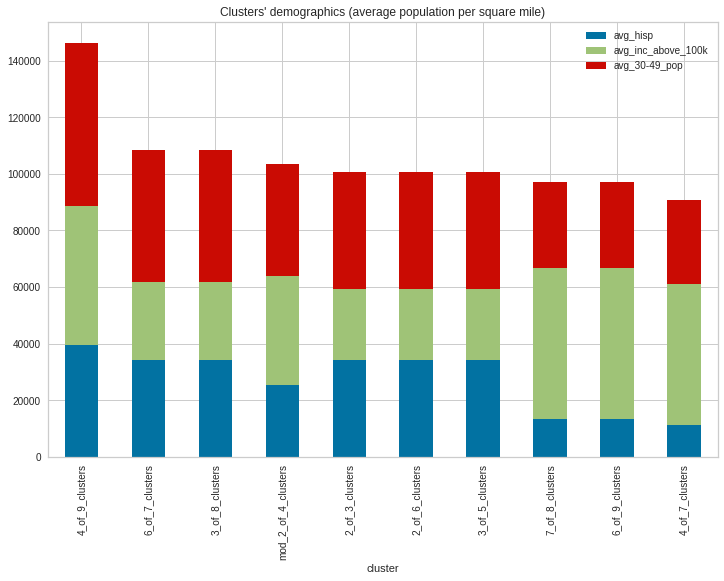

In [220]:
ax=ev_cl.iloc[:,:-1].plot(kind='bar',stacked=True,figsize=(12,8),title="Clusters' demographics (average population per square mile)")


<AxesSubplot:title={'center':"Clusters' land area (square miles)"}, xlabel='cluster'>

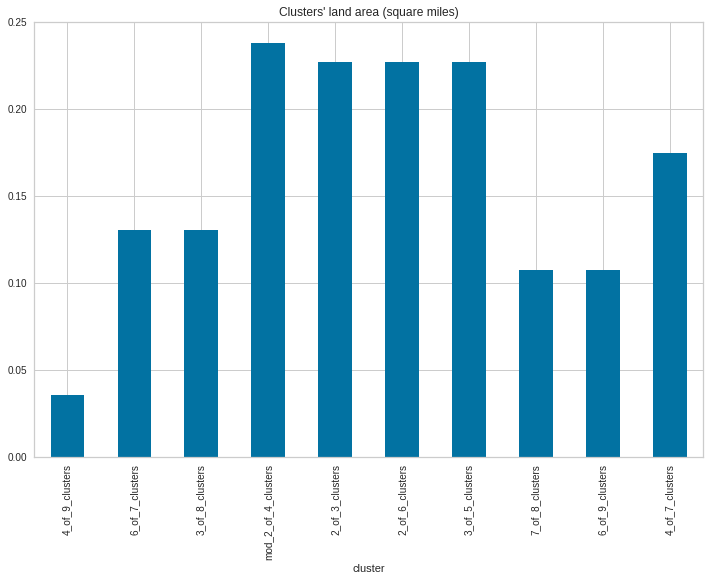

In [215]:
ev_cl.iloc[:,-1].plot(kind='bar',figsize=(12,8),title="Clusters' land area (square miles)")

The modified cluster 2 of 4 is a good balance between demographics parameters and size of the cluster. It is the largest and third out of the top ten clusters in terms of demographics. It contains both 4 of 9 and 6 of 7 clusters. Looking at the clusters' demograhics and the clusters' maps visualizations we observe that:

* the south-western part of cluster 2 of 4 has most preferable demographics in terms of Hispanic population and population aged 30-49
* the north eastern part of cluster 2 of 4 worse parameters as far as Hispanic population and population aged 30-49 are concerned is balanced by a higher population of with income above 100k USD

My initial recomendation would be to locate the Mexican restaurant in the middle of the modified 2 of 4 cluster to fully benefit from the overall beneficial, balanced cluster's demographics, its size as well as the vicinity to the the best in terms of demographics cluster 4 of 9 located to the south-west of the centre of the modified 2 of 4 cluster. But in order to confirm this I need to analyze the locations of the restaurant's direct competitors and other restaurants in cluster 2 of 4 and its adjacant areas.


Reading information about California census tracts.


In [198]:
ca_tracts=pd.read_csv('2019_gaz_tracts_06.txt',delimiter='\t',dtype={'GEOID': str})
ca_tracts

USPS        GEOID      ALAND    AWATER  ALAND_SQMI  AWATER_SQMI  \
0      CA  06001400100    6894339         0       2.662        0.000   
1      CA  06001400200     586559         0       0.226        0.000   
2      CA  06001400300    1105851         0       0.427        0.000   
3      CA  06001400400     715630         0       0.276        0.000   
4      CA  06001400500     590297         0       0.228        0.000   
...   ...          ...        ...       ...         ...          ...   
8052   CA  06115040800  109401417    128316      42.240        0.050   
8053   CA  06115040901  263652570   4473094     101.797        1.727   
8054   CA  06115040902   93617079    240059      36.146        0.093   
8055   CA  06115041000  468397390   6927408     180.849        2.675   
8056   CA  06115041100  559316286  17080393     215.953        6.595   

       INTPTLAT  \
0     37.867627   
1     37.848138   
2     37.840597   
3     37.848281   
4     37.848541   
...         ...   
8052  39.041053   
8053  39.139743   
8054  39.119345   
8055  39.266189   
8056  39.452244   

      INTPTLONG                                                                                                                               
0                                           -122.231946                                                                                       
1                                           -122.249592                                                                                       
2                                           -122.254440                                                                                       
3                                           -122.257448                                                                                       
4                                           -122.264728                                                                                       
...                                                 ...                                                                                       
8052                                        -121.433980                                                                                       
8053                                        -121.582340                                                                                       
8054                                        -121.399584                                                                                       
8055                                        -121.445373                                                                                       
8056                                        -121.182654                                                                                       

[8057 rows x 8 columns]

Subsetting information about California census tracts to San Francisco tracts.


In [199]:
ca_tracts['trint']=ca_tracts['GEOID'].astype(int)
sf_tracts=ca_tracts[(ca_tracts['trint']<=6075990100) & (ca_tracts['trint']>=6075010100)]
sf_tracts.drop(columns=['trint'],inplace=True)
sf_tracts.reset_index(drop=True,inplace=True)

sf_tracts.rename(columns={'INTPTLAT':'Lat',
                          'INTPTLONG                                                                                                                             ':'Lon'},inplace=True)
#sf_tracts['Tract Code']=sf_tracts['Tract Code']-6075000000
sf_tracts.drop(columns='USPS',inplace=True)
sf_tracts

/home/vladdie/miniconda3/envs/cap/lib/python3.9/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
/home/vladdie/miniconda3/envs/cap/lib/python3.9/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


GEOID    ALAND     AWATER  ALAND_SQMI  AWATER_SQMI        Lat  \
0    06075010100   776490     646917       0.300        0.250  37.808520   
1    06075010200   515957     295388       0.199        0.114  37.805861   
2    06075010300   268266          0       0.104        0.000  37.801620   
3    06075010400   335744          0       0.130        0.000  37.802273   
4    06075010500   683605     494314       0.264        0.191  37.802684   
..           ...      ...        ...         ...          ...        ...   
192  06075980401   419323  247501289       0.162       95.561  37.727239   
193  06075980501  1577311       9769       0.609        0.004  37.716208   
194  06075980600  2132298    2016110       0.823        0.778  37.723166   
195  06075980900  3585240     260707       1.384        0.101  37.746286   
196  06075990100        0   70939179       0.000       27.390  37.762160   

            Lon  
0   -122.409554  
1   -122.422925  
2   -122.415681  
3   -122.407558  
4   -122.399050  
..          ...  
192 -123.032229  
193 -122.419346  
194 -122.368542  
195 -122.389477  
196 -122.551862  

[197 rows x 7 columns]

In [200]:
sf_tracts.rename(columns={'GEOID':'trctid'},inplace=True)
sf_tracts

/home/vladdie/miniconda3/envs/cap/lib/python3.9/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


trctid    ALAND     AWATER  ALAND_SQMI  AWATER_SQMI        Lat  \
0    06075010100   776490     646917       0.300        0.250  37.808520   
1    06075010200   515957     295388       0.199        0.114  37.805861   
2    06075010300   268266          0       0.104        0.000  37.801620   
3    06075010400   335744          0       0.130        0.000  37.802273   
4    06075010500   683605     494314       0.264        0.191  37.802684   
..           ...      ...        ...         ...          ...        ...   
192  06075980401   419323  247501289       0.162       95.561  37.727239   
193  06075980501  1577311       9769       0.609        0.004  37.716208   
194  06075980600  2132298    2016110       0.823        0.778  37.723166   
195  06075980900  3585240     260707       1.384        0.101  37.746286   
196  06075990100        0   70939179       0.000       27.390  37.762160   

            Lon  
0   -122.409554  
1   -122.422925  
2   -122.415681  
3   -122.407558  
4   -122.399050  
..          ...  
192 -123.032229  
193 -122.419346  
194 -122.368542  
195 -122.389477  
196 -122.551862  

[197 rows x 7 columns]

In [201]:
demogr_sf_res_avg_mod_2_of_4=pd.merge(demogr_sf_res_avg_mod_2_of_4,sf_tracts,how='left',on='trctid')
demogr_sf_res_avg_mod_2_of_4

trctid      avg_hisp  avg_inc_above_100k  avg_30-49_pop  land_area  \
0  06075011901  12888.822728        67092.308299   28521.716668   0.024052   
1  06075011902  10075.717382        44032.553789   32815.663272   0.035928   
2  06075012100  17211.593520        48422.326451   30372.166392   0.047642   
3  06075012201  39646.417008        48909.843114   57851.690639   0.035539   
4  06075012202  24787.780445        25897.493424   40810.512473   0.035824   
5  06075012401  35230.077797         2559.619177   48437.835591   0.035509   
6  06075012502  37278.787221        32428.487648   40279.687407   0.023660   

   3_clusters  4_clusters  5_clusters  6_clusters  7_clusters  8_clusters  \
0           1           2           0           4           4           7   
1           1           2           0           4           4           7   
2           1           2           0           4           4           7   
3           2           2           3           2           6           3   
4           2           2           3           2           6           3   
5           2           2           3           2           6           3   
6           2           2           3           2           6           3   

   9_clusters   ALAND  AWATER  ALAND_SQMI  AWATER_SQMI        Lat         Lon  
0           6   62294       0       0.024          0.0  37.790473 -122.413914  
1           6   93053       0       0.036          0.0  37.790996 -122.409807  
2           6  123394       0       0.048          0.0  37.788807 -122.411888  
3           4   92048       0       0.036          0.0  37.785846 -122.416353  
4           7   92823       0       0.036          0.0  37.785412 -122.419644  
5           7   91972       0       0.036          0.0  37.783051 -122.415789  
6           7   61275       0       0.024          0.0  37.783933 -122.412595

I am downloading information using the Foursquare API about restaurants located in cluster_2_of_4 tracts and in its vicinity.

## 8. Downloading data about restaurants in cluster 2 of 4. <a name="8"></a>

In [202]:
CLIENT_ID = 'X' # your Foursquare ID
CLIENT_SECRET = 'X' # your Foursquare Secret
ACCESS_TOKEN = 'X' # your FourSquare Access Token
VERSION = '20180604'
LIMIT = 100

In [203]:
def get_nearby_venues(names,categories, latitudes, longitudes, radius=700):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print('Reading venues data of tract '+name+' and its vicinity.')
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&categoryId={}&radius={}&limit={}'.format(
                       CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            categories,
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]["groups"][0]["items"]
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['id'], 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name'],
            v['venue']['categories'][0]['id'],
        ) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list],columns = [
                  'trctid', 
                  'Tract Latitude', 
                  'Tract Longitude',
                  'Venue Id',
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category',
                  'Venue Category ID'
    ])
    print('Completed downloading data from Foursquare.')   
    return(nearby_venues)

In [204]:
import requests
def add_color(venue):# function to specify restaurants' marker colour depending on venue type
    if venue=='Mexican Restaurant':
        color='red'
    elif venue=='Taco Place':
        color='purple'
    elif venue=='Burrito Place':
        color='orange'
    else:
        color='blue'
    return color
def get_res(file='cl_2_of_4_mod_res.fea'):
    try:
        cl_2_of_4_mod_res=pd.read_feather(file)
    except:
        names= demogr_sf_res_avg_mod_2_of_4.loc[:,'trctid']
        longitudes= demogr_sf_res_avg_mod_2_of_4['Lon']
        latitudes= demogr_sf_res_avg_mod_2_of_4['Lat']
        food_cat='4d4b7105d754a06374d81259' #Foursquare food category
        cl_2_of_4_mod_venues= get_nearby_venues(names,food_cat,latitudes, longitudes)
        cl_2_of_4_mod_venues.drop_duplicates(subset='Venue Id',ignore_index=True,inplace=True)# dropping duplicate venues
        other_food_cat=['Sandwich Place','Café','Breakfast Spot','Bakery','Donut Shop','Irish Pub','Wagashi Place',
                        'Bagel Shop', 'Food Truck','Fast Food Restaurant','Snack Place']
        cl_2_of_4_mod_res=cl_2_of_4_mod_venues.drop(index=cl_2_of_4_mod_venues[
            cl_2_of_4_mod_venues['Venue Category'].isin(other_food_cat)].index).reset_index() # dropping venues other than restaurants   
        cl_2_of_4_mod_res.to_feather('cl_2_of_4_mod_res.fea')
    cl_2_of_4_mod_res['color']=cl_2_of_4_mod_res.apply(lambda x: add_color(x["Venue Category"]),axis=1) #adding markers colour information
    mex_categories=['4bf58dd8d48988d1c1941735','58daa1558bbb0b01f18ec1d9',
            '4bf58dd8d48988d153941735','4bf58dd8d48988d151941735',
            '56aa371ae4b08b9a8d5734ba','5744ccdfe4b0c0459246b4d3'
             ] #Foursquare Mexican restaurants, burrito and taco place categories
    mex_res=cl_2_of_4_mod_res[cl_2_of_4_mod_res['Venue Category ID'].isin(mex_categories)].reset_index() #Mexican restaurants, burrito and taco places
    return cl_2_of_4_mod_res,mex_res

Listing all the restaurant's in the area including their location data.

In [205]:
cl_2_of_4_mod_res,mex_res=get_res()
cl_2_of_4_mod_res

trctid  Tract Latitude  Tract Longitude                  Venue Id  \
0    06075011901       37.790473      -122.413914  5c0dd1ad5a2c91002c442f28   
1    06075011901       37.790473      -122.413914  44f72e06f964a5204b381fe3   
2    06075011901       37.790473      -122.413914  54c2a5e4498ee52a438800f7   
3    06075011901       37.790473      -122.413914  5643ce76498ec3c226f039e3   
4    06075011901       37.790473      -122.413914  59cb288d6c08d172265a8e6d   
..           ...             ...              ...                       ...   
210  06075012401       37.783051      -122.415789  4a2c0803f964a5200e971fe3   
211  06075012401       37.783051      -122.415789  5c40381f603d2a002c295ff9   
212  06075012401       37.783051      -122.415789  59a24aa726659b0902fb4d04   
213  06075012502       37.783933      -122.412595  4dfd856d483b96a3aaa9eb34   
214  06075012502       37.783933      -122.412595  4af09c87f964a520a1dd21e3   

                   Venue  Venue Latitude  Venue Longitude  \
0     Gusto Pinsa Romana       37.789594      -122.413873   
1       Big 4 Restaurant       37.791490      -122.412393   
2    Liholiho Yacht Club       37.788332      -122.414605   
3             Del Popolo       37.789807      -122.411347   
4                 Chisme       37.788467      -122.414802   
..                   ...             ...              ...   
210          Sam's Diner       37.778375      -122.415426   
211        The Pawn Shop       37.781060      -122.408548   
212            Oma Sushi       37.786124      -122.410247   
213          Box Kitchen       37.781158      -122.406243   
214                  Tín       37.780840      -122.405770   

            Venue Category         Venue Category ID color  
0       Italian Restaurant  4bf58dd8d48988d110941735  blue  
1      American Restaurant  4bf58dd8d48988d14e941735  blue  
2      Hawaiian Restaurant  52e81612bcbc57f1066b79fe  blue  
3              Pizza Place  4bf58dd8d48988d1ca941735  blue  
4       Mexican Restaurant  4bf58dd8d48988d1c1941735   red  
..                     ...                       ...   ...  
210                  Diner  4bf58dd8d48988d147941735  blue  
211       Tapas Restaurant  4bf58dd8d48988d1db931735  blue  
212       Sushi Restaurant  4bf58dd8d48988d1d2941735  blue  
213    American Restaurant  4bf58dd8d48988d14e941735  blue  
214  Vietnamese Restaurant  4bf58dd8d48988d14a941735  blue  

[215 rows x 10 columns]

mex_res

There are 11 Mexican restaurants, taco and burrito places in the analysed area. Let us visualize their locations on the map of the area using red markers for Mexican restaurants, purple -for taco places, orange -for burrito places and blue markers for other restaurants.

## 9.Visualising restaurants in cluster 2 of 4 and its vicinity on the map. <a name="9"></a>

In [241]:
import folium
import branca.colormap as cmp
clusters=demogr_sf_res_avg_mod.set_index('trctid')['4_clusters']+1
step = cmp.StepColormap(
 ['green','blue','yellow','gray','yellow'],
 vmin=0, vmax=4,
 index=[0,1, 2, 3,4,5],  #for change in the colors, not used fr linear
 caption='Clusters'    #Caption for Color scale or Legend
)
sanmap=folium.Map(zoom_start=15.5,location=[37.78646,-122.414462])
folium.GeoJson(geosan,style_function=lambda feature: {
    'fillColor':step(clusters[feature['properties']['trctid']]),
    'fillOpacity':0.6,
    'color':'black', #border color for the color fills
    'weight':1, #how thick the border has to be
    'dashArray': '5,3' #dashed lines length,space between them
}).add_to(sanmap)


from branca.element import Template, MacroElement

macro = MacroElement()
macro._template = Template(template1)

sanmap.get_root().add_child(macro)
for i in range(0,len(cl_2_of_4_mod_res)):
    folium.Marker(location=[cl_2_of_4_mod_res.iloc[i]['Venue Latitude'],cl_2_of_4_mod_res.iloc[i]['Venue Longitude']],
                  popup=cl_2_of_4_mod_res.iloc[i]['Venue Category']+ '<br>' +cl_2_of_4_mod_res.iloc[i]['Venue'],
                  icon = folium.Icon(color = "%s" % cl_2_of_4_mod_res.iloc[i]['color'])).add_to(sanmap)
folium.Circle(
    location=[37.78563562263323, -122.41801456618319],
    radius=200,
    popup="Proposed location of the Mexican restaurant",
    color="red",
    fill=False,
    weight=10
  ).add_to(sanmap)

sanmap.get_root().add_child(macro)
sanmap

## 10. Conclusion <a name="10"></a>

After plotting the restaurants on the cluster 2 of 4 map we have a clearer picture. There are two Mexican restaurants within one and two blocks away from the cluster's centre location so this is not the best place for another one. The western part of the cluster is the farthest from the other direct competitors. Taking into account all the previoius analysis I propose to locate the Mexican restaurant in area highlighted with the red circle next to the cluster 4 of 9 which is the best in terms of demographics, within a decent distance from the rest of the cluster and far enough from the direct competitors.  Presence of other restaurants in this area is a sign that there is a substantial footfall in this area with a potential to take over the competitors clients (certainly this should be analysed more thoroughly).

Of course this just a preliminary demographics and competetitors analysis. In order to make a final decision about the location of the restaurant many more factors should by analysed such as:

* visibility
* footfall
* parking
* available venues for rent and their rent rates
* surrounding businesses
* more in-depth analysis of the competitors
* safety and crime rates
* accessibility
* zoning regulations etc.


